## Analysis, part I

In [323]:
# Imports & Parameters
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
START_DATE = '2018-01-01'
END_DATE = '2026-06-01'
TICKERS = [
    'BTC-USD', 
    'ETH-USD', 
    #'XRP-USD', 'BNB-USD', 'SOL-USD', 
    #'TRX-USD', 'ADA-USD', 'DOGE-USD', 'ZEC-USD', 'LINK-USD'
]

SUB_PLOTS_X = 1
SUB_PLOTS_Y = 2

In [324]:
# Download data for all tickers and add features
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)

# Returns
returns = data['Close'].pct_change()
returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])

# Log Returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))
log_returns.columns = pd.MultiIndex.from_product([['LogReturns'], log_returns.columns])

# Next day returns (shifted returns)
next_day_returns = returns.shift(-1)
next_day_returns.columns = pd.MultiIndex.from_product([['NextDayReturns'], TICKERS])

# 20-day momentum (cumulative return over past 20 days)
momentum_20d = data['Close'].pct_change(periods=20)
momentum_20d.columns = pd.MultiIndex.from_product([['Momentum20D'], momentum_20d.columns])

# Concatenate with original data
data = pd.concat([data, returns, log_returns, momentum_20d], axis=1)

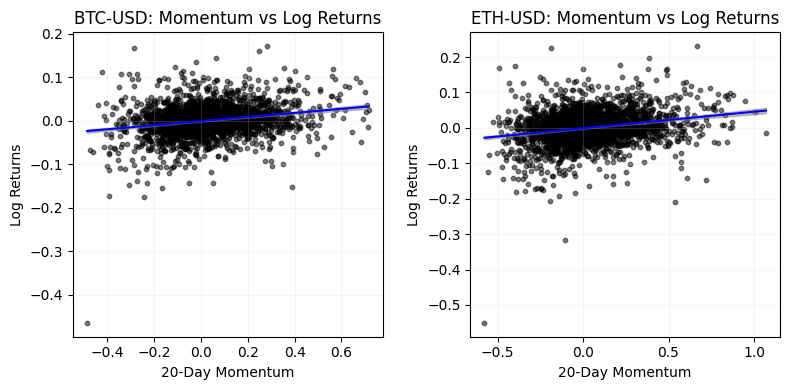

In [325]:
# Momentum vs Log Returns Scatter Plots with Regression Lines

# Create subplots
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    # Prepare data for this ticker
    df_clean = pd.DataFrame({
        'momo20': momentum_20d[('Momentum20D', ticker)],
        'log_return': log_returns[('LogReturns', ticker)]
    }).dropna()
    
    # Fit regression model using numpy
    X = df_clean['momo20'].values
    y = df_clean['log_return'].values
    
    # Add constant term (intercept)
    X_with_const = np.column_stack([np.ones(len(X)), X])
    
    # Calculate coefficients using least squares
    coeffs = np.linalg.lstsq(X_with_const, y, rcond=None)[0]
    intercept, slope = coeffs
    
    # Calculate R-squared
    y_pred = intercept + slope * X
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Create grid for prediction
    x_grid = np.linspace(X.min(), X.max(), 200)
    y_grid = intercept + slope * x_grid
    
    # Calculate standard error and confidence intervals
    n = len(X)
    residuals = y - y_pred
    mse = np.sum(residuals ** 2) / (n - 2)
    se = np.sqrt(mse * (1/n + (x_grid - X.mean())**2 / np.sum((X - X.mean())**2)))
    ci_margin = 1.96 * se  # 95% confidence interval
    
    # Plot scatter and regression line
    ax.scatter(X, y, s=10, color='black', alpha=0.5)
    ax.plot(x_grid, y_grid, color='blue', linewidth=1.5, label='Regression Line')
    ax.fill_between(x_grid, y_grid - ci_margin, y_grid + ci_margin, color='gray', alpha=0.5, label='95% CI')
    
    ax.set_xlabel('20-Day Momentum')
    ax.set_ylabel('Log Returns')
    ax.set_title(f'{ticker}: Momentum vs Log Returns')
    #ax.legend()
    ax.grid(True, alpha=0.2, color='lightgray')

plt.tight_layout()
plt.show()

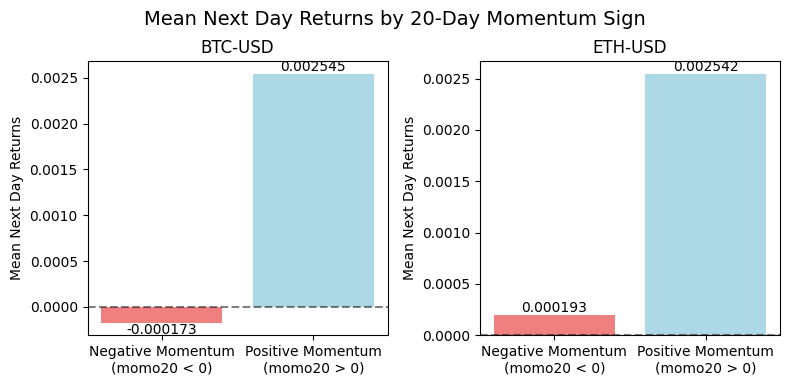

In [326]:
# Next Day Returns by Momentum Sign

# Create subplots for momentum analysis
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle('Mean Next Day Returns by 20-Day Momentum Sign', fontsize=14, y=0.95)

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    # Prepare data for this ticker
    df_analysis = pd.DataFrame({
        'momo20': momentum_20d[('Momentum20D', ticker)],
        'next_day_return': next_day_returns[('NextDayReturns', ticker)]
    }).dropna()
    
    # Split into positive and negative momentum
    positive_momo_returns = df_analysis[df_analysis['momo20'] > 0]['next_day_return']
    negative_momo_returns = df_analysis[df_analysis['momo20'] < 0]['next_day_return']
    
    # Calculate means
    mean_positive = positive_momo_returns.mean()
    mean_negative = negative_momo_returns.mean()
    
    # Create histogram
    ax.bar(['Negative Momentum\n(momo20 < 0)', 'Positive Momentum\n(momo20 > 0)'], 
           [mean_negative, mean_positive],
           color=['lightcoral', 'lightblue'],
           alpha=1)
    
    ax.set_ylabel('Mean Next Day Returns')
    ax.set_title(f'{ticker}')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    ax.text(0, mean_negative, f'{mean_negative:.6f}', 
            ha='center', va='bottom' if mean_negative > 0 else 'top')
    ax.text(1, mean_positive, f'{mean_positive:.6f}', 
            ha='center', va='bottom' if mean_positive > 0 else 'top')

plt.tight_layout()
plt.show()

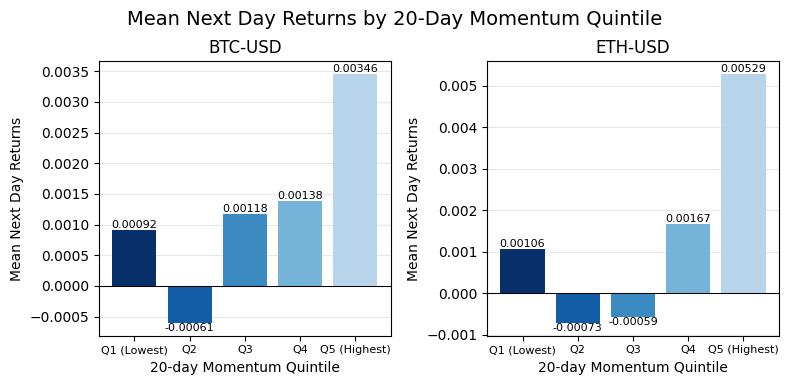

In [327]:
# Next Day Returns by Momentum Quintiles (mean)

# Create subplots for quintile analysis
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle('Mean Next Day Returns by 20-Day Momentum Quintile', fontsize=14, y=0.95)

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    # Prepare data for this ticker
    df_quintile = pd.DataFrame({
        'momo20': momentum_20d[('Momentum20D', ticker)],
        'next_day_return': next_day_returns[('NextDayReturns', ticker)]
    }).dropna().copy()
    
    # Create quintiles based on 20-day momentum
    df_quintile['quintile'] = pd.qcut(df_quintile['momo20'], q=5, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)'])
    
    # Calculate mean next day return for each quintile
    quintile_means = df_quintile.groupby('quintile', observed=True)['next_day_return'].mean()
    
    # Create histogram
    colors = [cm.Blues(x) for x in np.linspace(1, 0.3, 5)]
    ax.bar(range(len(quintile_means)), quintile_means.values, color=colors, alpha=1, zorder=2)
    
    ax.set_xticks(range(len(quintile_means)))
    ax.set_xticklabels(quintile_means.index, rotation=0, fontsize=8)
    ax.set_xlabel('20-day Momentum Quintile')
    ax.set_ylabel('Mean Next Day Returns')
    ax.set_title(f'{ticker}')
    ax.axhline(y=0, color='black', linestyle='-', alpha=1, linewidth=0.75, zorder=3)
    ax.grid(True, alpha=0.3, axis='y', zorder=1)
    
    # Add value labels on bars
    for i, v in enumerate(quintile_means.values):
        ax.text(i, v, f'{v:.5f}', ha='center', va='bottom' if v > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

## Backtest, part I

### Simple Binary Strategy

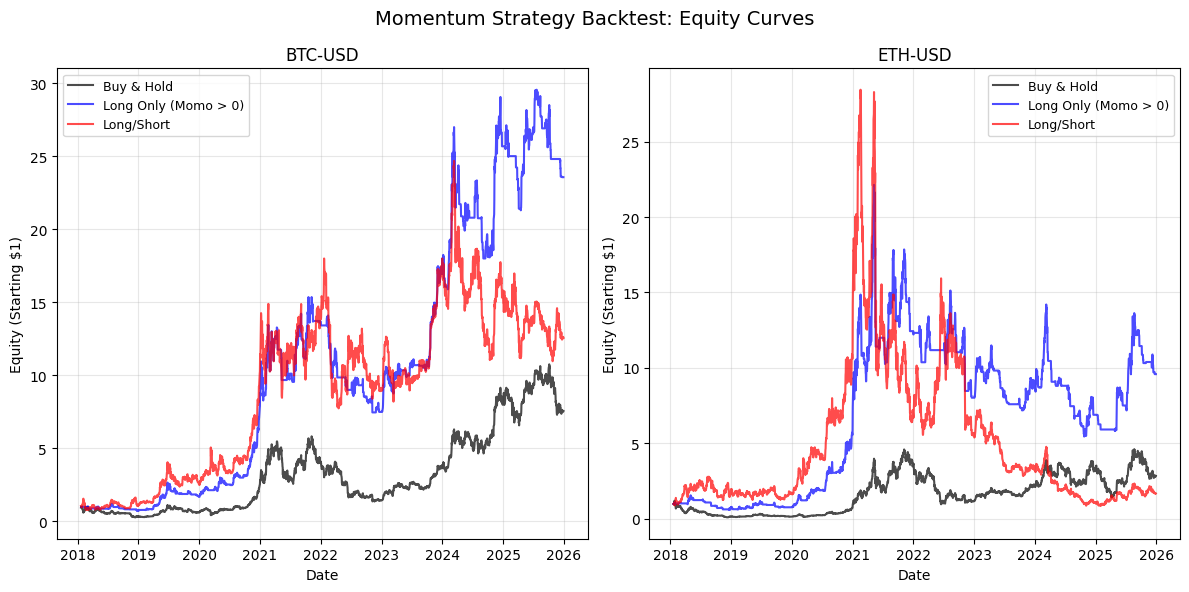

In [328]:
# Backtest: Simple Binary Strategy

# Create subplots
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(12, 6))
fig.suptitle('Momentum Strategy Backtest: Equity Curves', fontsize=14, y=0.98)

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    # Prepare data for this ticker
    df_backtest = pd.DataFrame({
        'next_day_returns': next_day_returns[('NextDayReturns', ticker)],
        'momo20': momentum_20d[('Momentum20D', ticker)]
    }).dropna().copy()
    
    # Benchmark: Buy and Hold (using next day returns for fair comparison)
    df_backtest['benchmark_equity'] = (1 + df_backtest['next_day_returns']).cumprod()
    
    # Strategy 1: Long only when momentum is positive
    df_backtest['strategy1_returns'] = df_backtest['next_day_returns'].where(
        df_backtest['momo20'] > 0, 0
    )
    df_backtest['strategy1_equity'] = (1 + df_backtest['strategy1_returns']).cumprod()
    
    # Strategy 2: Long/Short based on momentum sign
    df_backtest['strategy2_returns'] = df_backtest['next_day_returns'].where(
        df_backtest['momo20'] > 0, -df_backtest['next_day_returns']
    )
    df_backtest['strategy2_equity'] = (1 + df_backtest['strategy2_returns']).cumprod()
    
    # Plot equity curves
    ax.plot(df_backtest.index, df_backtest['benchmark_equity'], 
            label='Buy & Hold', color='black', linewidth=1.5, alpha=0.7)
    ax.plot(df_backtest.index, df_backtest['strategy1_equity'], 
            label='Long Only (Momo > 0)', color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(df_backtest.index, df_backtest['strategy2_equity'], 
            label='Long/Short', color='red', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Equity (Starting $1)')
    ax.set_title(f'{ticker}')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis, part II

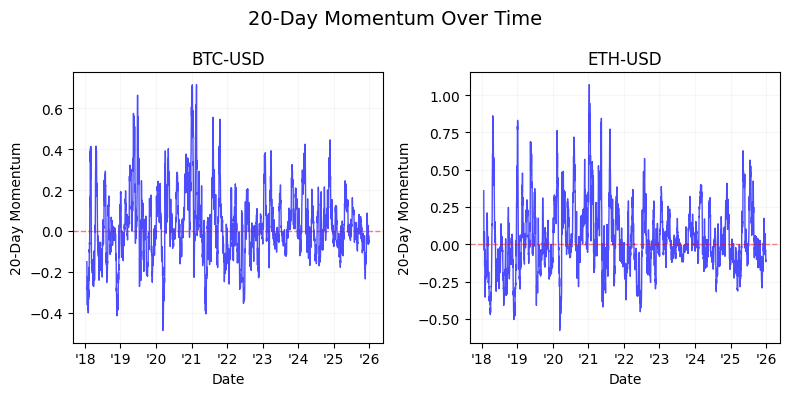

In [329]:
# Plot 20-day momentum for both tickers
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle('20-Day Momentum Over Time', fontsize=14, y=0.98)

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    ax.plot(momentum_20d.index, momentum_20d[('Momentum20D', ticker)], 
            linewidth=1, alpha=0.7, color='blue')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('20-Day Momentum')
    ax.set_title(f'{ticker}')
    ax.grid(True, alpha=0.2, color='lightgray')
    
    # Format x-axis to show only last 2 digits of year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("'%y"))

plt.tight_layout()
plt.show()

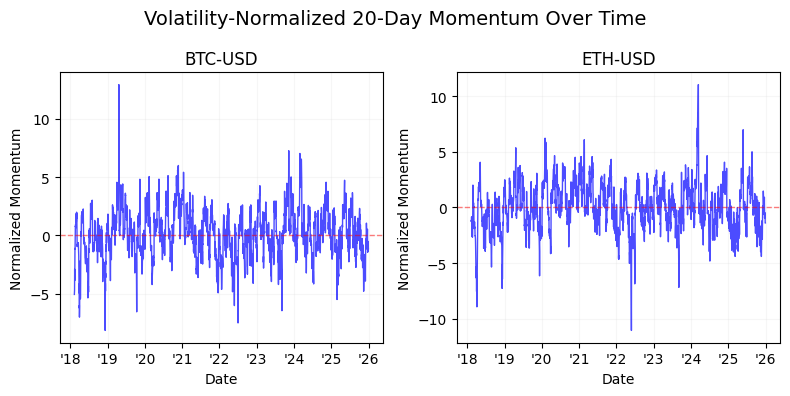

In [330]:
# Volatility-normalized momentum
volatility_20d = momentum_20d['Momentum20D'].rolling(window=20).std()
volatility_20d.columns = pd.MultiIndex.from_product([['Volatility20D'], volatility_20d.columns])

# Normalized momentum = momentum / volatility
# Extract the ticker-level data for both to align them properly
momentum_values = momentum_20d['Momentum20D']
volatility_values = volatility_20d['Volatility20D']

normalized_momentum_20d = momentum_values / volatility_values
normalized_momentum_20d.columns = pd.MultiIndex.from_product([['NormalizedMomentum20D'], TICKERS])

# Add to data
data = pd.concat([data, volatility_20d, normalized_momentum_20d], axis=1)

# Plot normalized momentum for both tickers
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle('Volatility-Normalized 20-Day Momentum Over Time', fontsize=14, y=0.98)

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    ax.plot(normalized_momentum_20d.index, normalized_momentum_20d[('NormalizedMomentum20D', ticker)], 
            linewidth=1, alpha=0.7, color='blue')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Normalized Momentum')
    ax.set_title(f'{ticker}')
    ax.grid(True, alpha=0.2, color='lightgray')
    
    # Format x-axis to show only last 2 digits of year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("'%y"))

plt.tight_layout()
plt.show()

### Bounding with tanh squashing

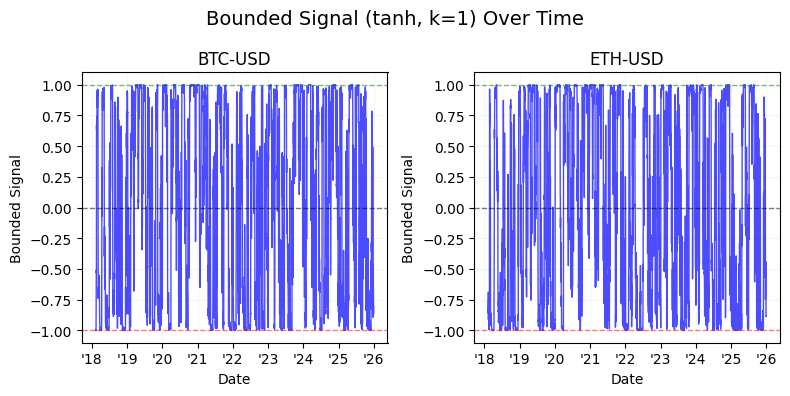

In [331]:
# Bounded signal using tanh squashing with k=2
k = 1
bounded_signal = np.tanh(normalized_momentum_20d / k)
bounded_signal.columns = pd.MultiIndex.from_product([['BoundedSignal'], TICKERS])

# Plot bounded signal for both tickers
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle(f'Bounded Signal (tanh, k={k}) Over Time', fontsize=14, y=0.98)

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    ax.plot(bounded_signal.index, bounded_signal[('BoundedSignal', ticker)], 
            linewidth=1, alpha=0.7, color='blue')
    ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=-1, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Bounded Signal')
    ax.set_title(f'{ticker}')
    ax.grid(True, alpha=0.2, color='lightgray')
    ax.set_ylim([-1.1, 1.1])
    
    # Format x-axis to show only last 2 digits of year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("'%y"))

plt.tight_layout()
plt.show()

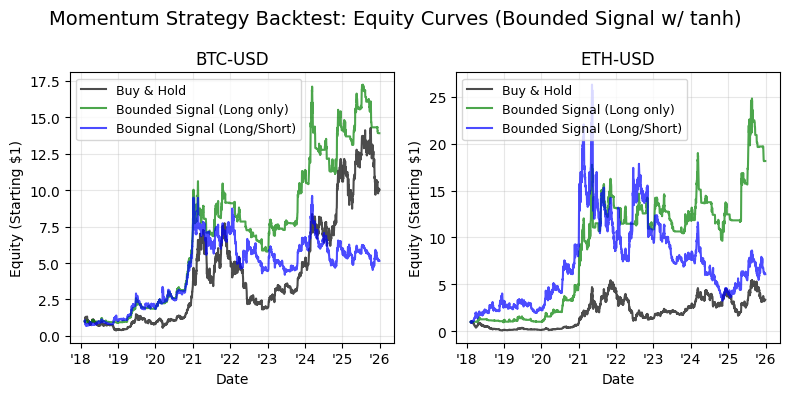

In [332]:
# Backtest: Bounded Signal Strategy with tanh squashing

# Create subplots
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle('Momentum Strategy Backtest: Equity Curves (Bounded Signal w/ tanh)', fontsize=14, y=0.98)

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    # Prepare data for this ticker
    df_bounded = pd.DataFrame({
        'next_day_returns': next_day_returns[('NextDayReturns', ticker)],
        'bounded_signal': bounded_signal[('BoundedSignal', ticker)]
    }).dropna().copy()
    
    # Benchmark: Buy and Hold
    df_bounded['benchmark_equity'] = (1 + df_bounded['next_day_returns']).cumprod()
    
    # Strategy: Bounded signal - long only (only take position when signal > 0)
    df_bounded['returns_k'] = df_bounded['next_day_returns'] * df_bounded['bounded_signal'].clip(lower=0)
    df_bounded['equity_k'] = (1 + df_bounded['returns_k']).cumprod()

    # Strategy: Bounded signal - long/short (use signal as weight)
    df_bounded['returns_bounded_ls'] = df_bounded['next_day_returns'] * df_bounded['bounded_signal']
    df_bounded['equity_bounded_ls'] = (1 + df_bounded['returns_bounded_ls']).cumprod()

    # Plot equity curves
    ax.plot(df_bounded.index, df_bounded['benchmark_equity'], 
            label='Buy & Hold', color='black', linewidth=1.5, alpha=0.7)
    ax.plot(df_bounded.index, df_bounded['equity_k'], 
            label='Bounded Signal (Long only)', color='green', linewidth=1.5, alpha=0.7)
    ax.plot(df_bounded.index, df_bounded['equity_bounded_ls'], 
            label='Bounded Signal (Long/Short)', color='blue', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Equity (Starting $1)')
    ax.set_title(f'{ticker}')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

    # Format x-axis to show only last 2 digits of year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("'%y"))

plt.tight_layout()
plt.show()

### Bounding with fixed -1.5, 1.5 limits

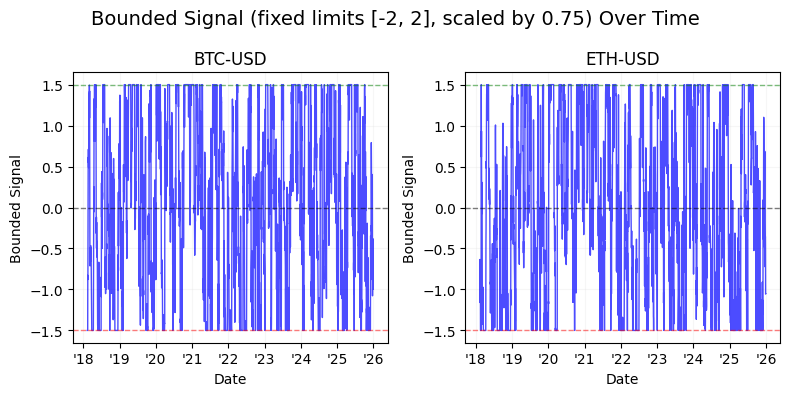

In [333]:
# Bounded signal using fixed limits -2, 2 and scaled by 0.75
lower_limit = -2
upper_limit = 2
scale_factor = 0.75

bounded_signal_fixed = normalized_momentum_20d.clip(lower=lower_limit, upper=upper_limit) * scale_factor
bounded_signal_fixed.columns = pd.MultiIndex.from_product([['BoundedSignalFixed'], TICKERS])

# Plot bounded signal for both tickers
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle(f'Bounded Signal (fixed limits [{lower_limit}, {upper_limit}], scaled by {scale_factor}) Over Time', fontsize=14, y=0.98)

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    ax.plot(bounded_signal_fixed.index, bounded_signal_fixed[('BoundedSignalFixed', ticker)], 
            linewidth=1, alpha=0.7, color='blue')
    ax.axhline(y=upper_limit * scale_factor, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=lower_limit * scale_factor, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Bounded Signal')
    ax.set_title(f'{ticker}')
    ax.grid(True, alpha=0.2, color='lightgray')
    ax.set_ylim([lower_limit * scale_factor * 1.1, upper_limit * scale_factor * 1.1])
    
    # Format x-axis to show only last 2 digits of year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("'%y"))

plt.tight_layout()
plt.show()

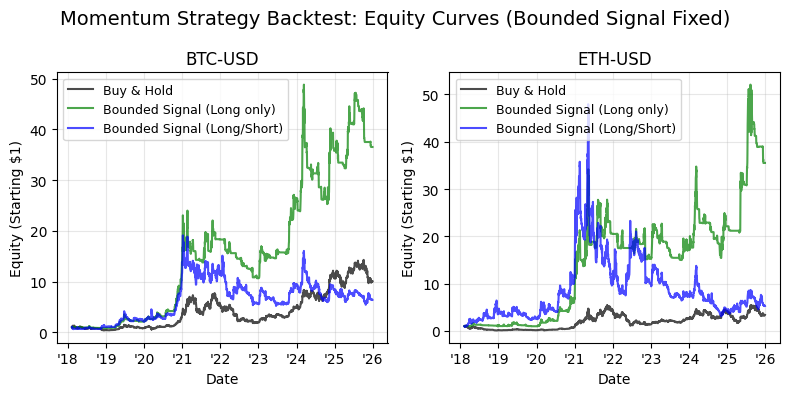

In [334]:
# Backtest: Bounded Signal Strategy with fixed limits

# Create subplots
fig, axes = plt.subplots(SUB_PLOTS_X, SUB_PLOTS_Y, figsize=(8, 4))
fig.suptitle('Momentum Strategy Backtest: Equity Curves (Bounded Signal Fixed)', fontsize=14, y=0.98)

# Iterate through each ticker
for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    # Prepare data for this ticker
    df_bounded_fixed = pd.DataFrame({
        'next_day_returns': next_day_returns[('NextDayReturns', ticker)],
        'bounded_signal_fixed': bounded_signal_fixed[('BoundedSignalFixed', ticker)]
    }).dropna().copy()
    
    # Benchmark: Buy and Hold (= 100% long)
    df_bounded_fixed['benchmark_equity'] = (1 + df_bounded_fixed['next_day_returns']).cumprod()
    
    # Strategy: Bounded signal - long only (only take position when signal > 0)
    df_bounded_fixed['returns_k'] = df_bounded_fixed['next_day_returns'] * df_bounded_fixed['bounded_signal_fixed'].clip(lower=0)
    df_bounded_fixed['equity_k'] = (1 + df_bounded_fixed['returns_k']).cumprod()
    
    # Strategy: Bounded signal - long/short (use signal as weight)
    df_bounded_fixed['returns_bounded_ls'] = df_bounded_fixed['next_day_returns'] * df_bounded_fixed['bounded_signal_fixed']
    df_bounded_fixed['equity_bounded_ls'] = (1 + df_bounded_fixed['returns_bounded_ls']).cumprod()

    # Plot equity curves
    ax.plot(df_bounded_fixed.index, df_bounded_fixed['benchmark_equity'], 
            label='Buy & Hold', color='black', linewidth=1.5, alpha=0.7)
    ax.plot(df_bounded_fixed.index, df_bounded_fixed['equity_k'], 
            label='Bounded Signal (Long only)', color='green', linewidth=1.5, alpha=0.7)
    ax.plot(df_bounded_fixed.index, df_bounded_fixed['equity_bounded_ls'], 
            label='Bounded Signal (Long/Short)', color='blue', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Equity (Starting $1)')
    ax.set_title(f'{ticker}')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

    # Format x-axis to show only last 2 digits of year
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("'%y"))

plt.tight_layout()
plt.show()